<a href="https://colab.research.google.com/github/mirinx/EEG_DECODING/blob/main/EEG_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install mne moabb scikit-learn matplotlib
import mne
from moabb.datasets import BNCI2014001
from moabb.paradigms import LeftRightImagery

dataset = BNCI2014001()
subject_id = [1]

paradigm = LeftRightImagery()
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=subject_id)


print(f"Trials: {X.shape[0]}")
print(f"Channels/Electrodes: {X.shape[1]}")
print(f"Time points: {X.shape[2]}")
print(f"Class: {set(labels)}")

Trials: 288
Channels/Electrodes: 22
Time points: 1001
Class: {np.str_('right_hand'), np.str_('left_hand')}


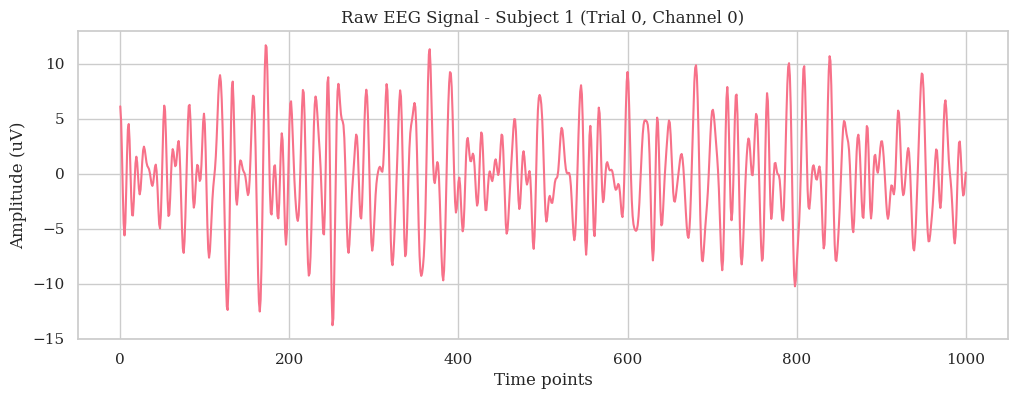

In [6]:
import matplotlib.pyplot as plt

sample_signal = X[0, 0, :]

plt.figure(figsize=(12, 4))
plt.plot(sample_signal)
plt.title("Raw EEG Signal - Subject 1 (Trial 0, Channel 0)")
plt.xlabel("Time points")
plt.ylabel("Amplitude (uV)")
plt.show()

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



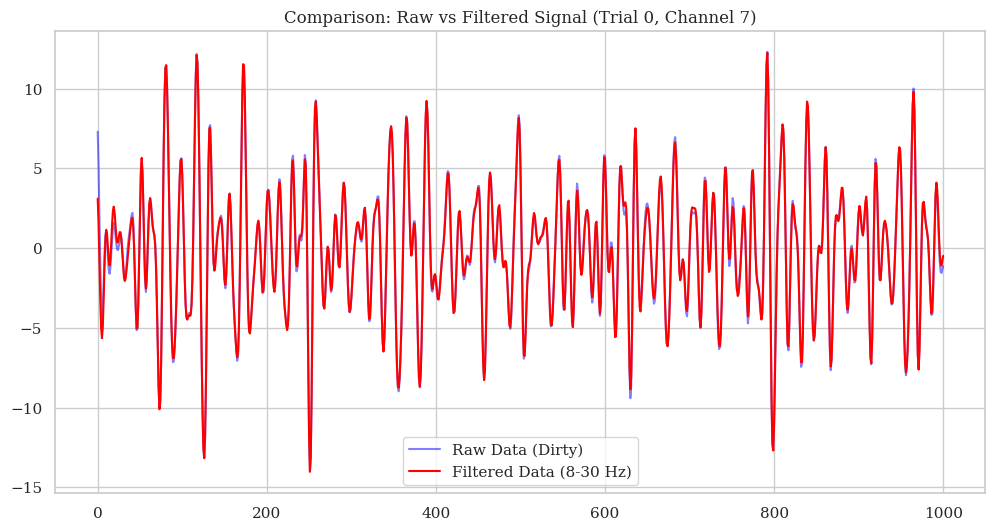

In [11]:

import numpy as np

ch_names = [f'EEG {i+1:03d}' for i in range(X.shape[1])]

info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types='eeg')
epochs = mne.EpochsArray(X, info)

epochs_filtered = epochs.copy().filter(l_freq=8.0, h_freq=30.0)

import matplotlib.pyplot as plt

trial_no = 0
channel_no = 7

plt.figure(figsize=(12, 6))
plt.plot(X[trial_no, channel_no, :], label='Raw Data (Dirty)', alpha=0.5, color='blue')
plt.plot(epochs_filtered.get_data()[trial_no, channel_no, :], label='Filtered Data (8-30 Hz)', color='red')
plt.title(f"Comparison: Raw vs Filtered Signal (Trial {trial_no}, Channel {channel_no})")
plt.legend()
plt.show()

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
from sklearn.model_selection import train_test_split


labels_numeric = np.where(labels == 'left_hand', 0, 1)
X_data = epochs_filtered.get_data()

X_train, X_test, y_train, y_test = train_test_split(X_data, labels_numeric, test_size=0.2, random_state=42)

csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()

clf = Pipeline([('CSP', csp), ('LDA', lda)])

clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)

print(f"Accuracy: {accuracy * 100:.2f}%")

Computing rank from data with rank=None
    Using tolerance 46 (2.2e-16 eps * 22 dim * 9.4e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Accuracy: 94.83%
